In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), mismatched flags (10))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

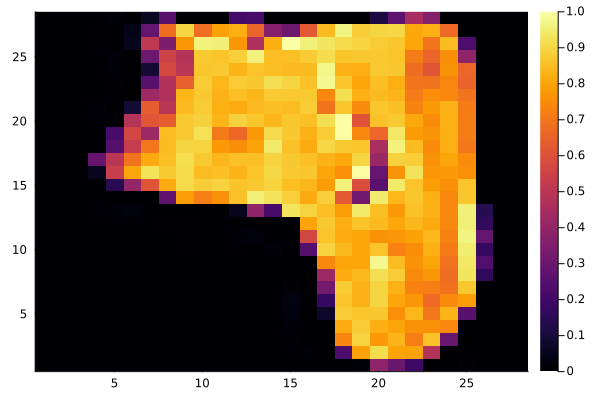

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [16]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [17]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),            # 100_480 parameters
    layer_4 = Dense(128 => 10),                   # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [18]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [19]:
yp, _ = model(x0, ps, st);

In [20]:
yp |> size

(10, 128)

In [21]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [22]:
loss_function(x0, y0, model, ps, st)

2.864157f0

In [23]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.864157f0, 2.565944f0, 2.3870642f0, 2.1986299f0, 2.1483345f0, 1.8518925f0, 1.7919457f0, 1.6326871f0, 1.6997683f0, 1.5456716f0  …  0.19584638f0, 0.18377113f0, 0.14342228f0, 0.2399824f0, 0.22279909f0, 0.1639145f0, 0.22647533f0, 0.22042538f0, 0.09459875f0, 0.15405577f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.037132423; 0.018166933; … ; 0.047308337; 0.018762916;;], scale = Float32[0.97007614; 0.9833207; … ; 0.97101045; 0.9863008;;]), layer_3 = (weight = Float32[0.009183565 0.11763307 … -0.07875581 0.10873151; -0.08290046 0.063954666 … 0.08223024 -0.08753904; … ; 0.07419505 -0.1251806 … -0.039771993 -0.10997044; 0.08038877 -0.044300284 … 0.03718059 0.03500325], bias = Float32[0.0028079103, 0.00020693394, -0.00633479, 0.011354098, -0.00249659, -0.012965338, 0.02431592, 0.008818084, 0.04466096, 0.012292594  …  -0.0047294684, -0.010059289, 0.0021118, 0.018612402, 0.010906254, 0.046910807, 0.01339833, 0.0034559832, 0.03459533, -0.045381803]), layer_4 = (weight = Float32[0.2

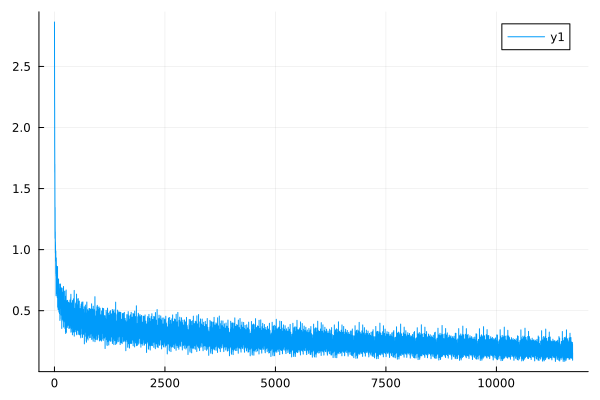

In [24]:
plot(losses)

In [25]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [26]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [27]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [28]:
test(model, test_loader, pst, stt)

0.882

In [29]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [30]:
#automate_train(64, 5)

# Test Phasor network

In [31]:
import .PhasorNetworks: default_bias

In [36]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 128, soft_angle, init_bias=default_bias),
            Codebook(128 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#37),
    layer_4 = WrappedFunction(#38),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 128, use_bias=false),  # 16_384 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_7 = Codebook(128 => 10),                # 1_280 parameters
)         # Total: 120_096 parameters,
          #        plus 0 states.

In [37]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0008010405 -0.0024223165 … -0.0026604207 -0.052246522; -0.05784539 0.038866077 … -0.014191841 0.054047313; … ; -0.047871105 -0.012310346 … -0.036755353 0.026587926; -0.055613305 -0.026476443 … 0.021711031 -0.0016106424],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.13288157 -0.069315806 … -0.044794213 -0.050002977; -0.10436164 0.09202711 … 0.09957697 -0.1338566; … ; 0.13919453 0.0930748 … -0.0091355 0.047809806; -0.045554675 -0.08742275 … -0.11126918 -0.037248205],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [38]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.004218653 0.04802253 … -0.08069007 0.013784209; -0.008417673 0.020303572 … -0.018622791 -0.06260933; … ; -0.031547397 0.061772354 … -0.090905115 -0.019431073; 0.015012819 -0.0061569177 … -0.09372944 -0.0066359155], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple()))

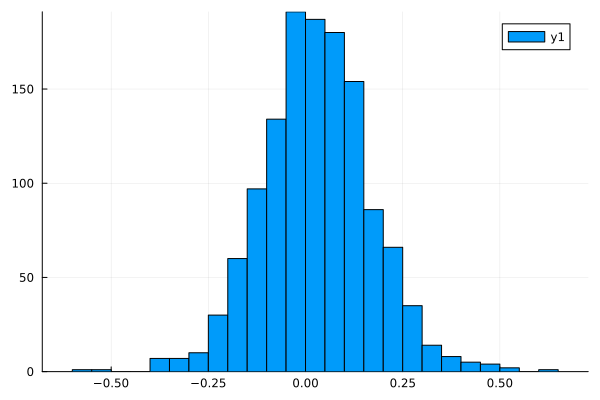

In [ ]:
histogram(cdev(vec(yp0)))

In [ ]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = quadrature_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [37]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.18832983f0

In [38]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CPU


(Any[0.18832983f0, 0.23266299f0, 0.16480933f0, 0.12653284f0, 0.09437292f0, 0.0927767f0, 0.07870408f0, 0.0812169f0, 0.08393672f0, 0.08166429f0  …  0.016024679f0, 0.01263086f0, 0.009324731f0, 0.017166922f0, 0.018802838f0, 0.0141887255f0, 0.017316837f0, 0.018869903f0, 0.009884078f0, 0.0131148f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.004804775; -0.21193779; … ; -0.0028808855; -0.60156524;;], scale = Float32[0.83579594; 0.86603767; … ; 0.8224306; 1.1722299;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.58569604 0.078917466 … 0.39916506 0.06277647; -0.13368098 -0.06353779 … -0.055606987 -0.026376111; … ; -0.2859442 -0.11167789 … -0.12234548 -0.039660074; 0.24227792 -0.22543348 … 0.12884209 -2.1374013],), bias = (bias_real = Float32[1.3438973, 1.180875, 1.3609117, 0.6919404, 1.161674, 1.1207178, 1.2267889, 1.4166783, 2.1542256, 0.9041055  …  1.3779038, 1.5271198, 1.226831, 1.4251136, 2.7825134, 0.9431831, -0.8887222, 1.1886474, 0.8

In [39]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.3438973, 1.180875, 1.3609117, 0.6919404, 1.161674, 1.1207178, 1.2267889, 1.4166783, 2.1542256, 0.9041055  …  1.3779038, 1.5271198, 1.226831, 1.4251136, 2.7825134, 0.9431831, -0.8887222, 1.1886474, 0.8489202, 2.225473], bias_imag = Float32[-0.7042714, 0.102049366, -0.23397243, 0.63236374, -0.24334694, 0.0954148, -0.32847401, 0.22677134, -0.20794061, 0.25468743  …  -0.9778805, -0.8307653, -0.22986427, 0.49034548, 0.0380029, 0.13232604, -0.05447206, -0.39634308, 0.2509009, -0.100901835])

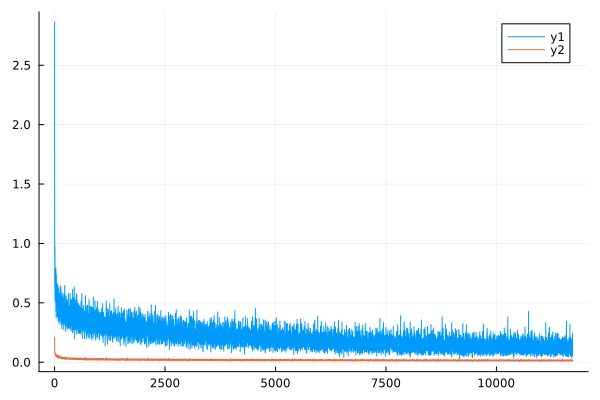

In [40]:
plot(losses)
plot!(log1p.(losses_f))

In [41]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_quadrature(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [42]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8762

# Test spiking behavior

In [43]:
spk_model = Chain(FlattenLayer(),
                    LayerNorm((28^2,)),
                    x -> tanh.(x), 
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
                PhasorDense(128 => 10, soft_angle, init_bias=default_bias),
                )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#37),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 103_476 parameters,
          #        plus 0 states.

In [44]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.0014083323 -0.04507559 … -0.044261027 -0.00018680228; 0.003962174 -0.029576467 … -0.022356845 0.061447885; … ; -0.01731993 0.029313562 … 0.042560346 0.009001352; -0.03792047 -0.02629939 … 0.018117055 -0.028354133],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.0019824742 -0.049997322 … -0.10292079 -0.13125014; -0.14316005 -0.13647507 … 0.030841118 0.017682927; … ; 0.062439285 -0.115413204 … 0.039782617 -0.024250269; 0.08007526 0.07600044 … 0.012436089 0.036774505],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [45]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(Spike Train: (10, 128) with 25599 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple())))

In [46]:
ys0.train

Spike Train: (10, 128) with 25599 spikes.

In [47]:
ys0.t_span

(0.0f0, 20.0f0)

In [48]:
st1 = get_time(ys0.train, (5.0, 10.0))

LoadError: UndefVarError: `get_time` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
st1_b1 = st1[:,1:10]

Spike Train: (10, 10) with 500 spikes.

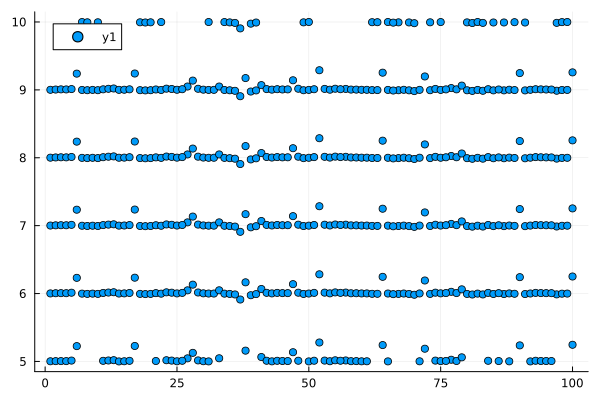

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

In [49]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (10, 128) with 25600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple())))

In [50]:
y_spk_f

SpikingCall(Spike Train: (10, 128) with 25600 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0))

In [51]:
y_p_f = train_to_phase(y_spk_f);

In [52]:
size(y_p_f)

(20, 10, 128)

In [55]:
st2 = get_time(y_spk_f.train, (5.5, 6.5))

Spike Train: (10, 128) with 1280 spikes.

In [56]:
st2_b1 = st2[:,1:10]

Spike Train: (10, 10) with 100 spikes.

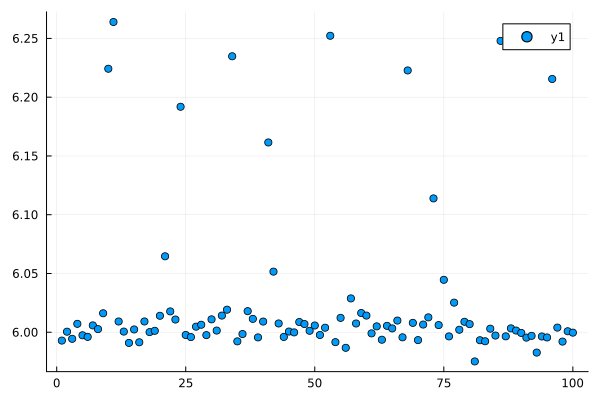

In [57]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

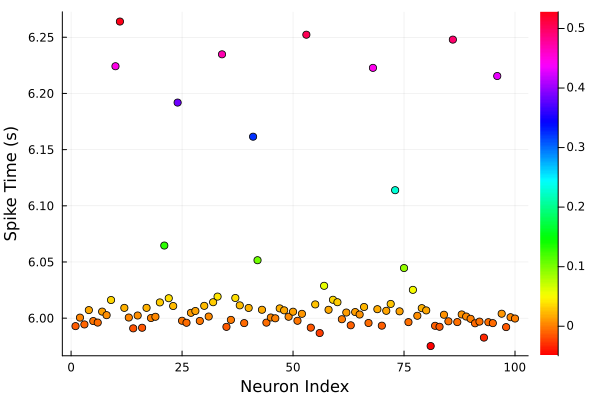

In [58]:
fig = scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times, marker_z=vec(y_p_f[5,:,1:10]), c = :hsv, legend=false, colorbar=true)
xlabel!("Neuron Index")
ylabel!("Spike Time (s)")

In [59]:
png(fig, "../figures/phase_scatter.png")

LoadError: SystemError: opening file "../figures/phase_scatter.png": No such file or directory

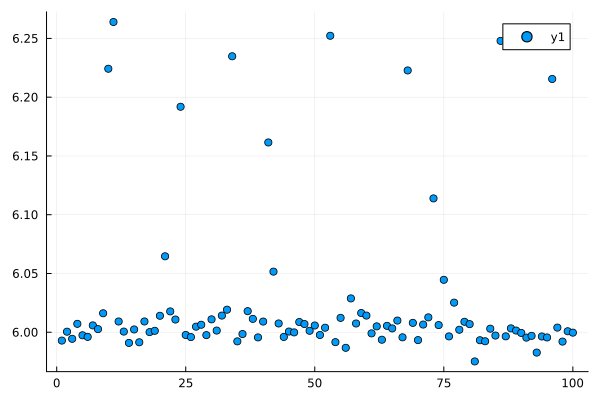

In [60]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

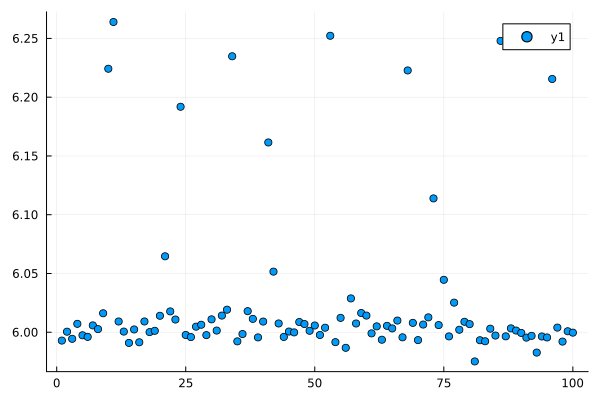

In [61]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

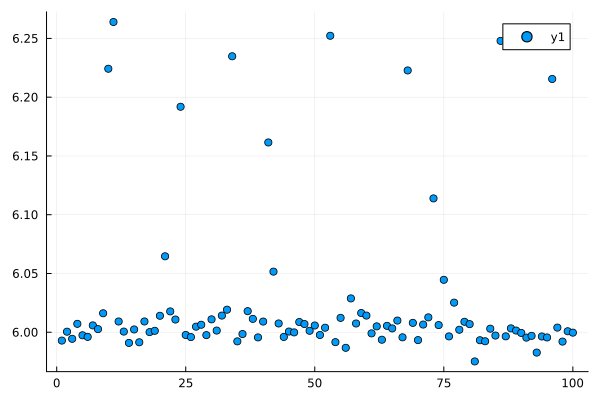

In [62]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

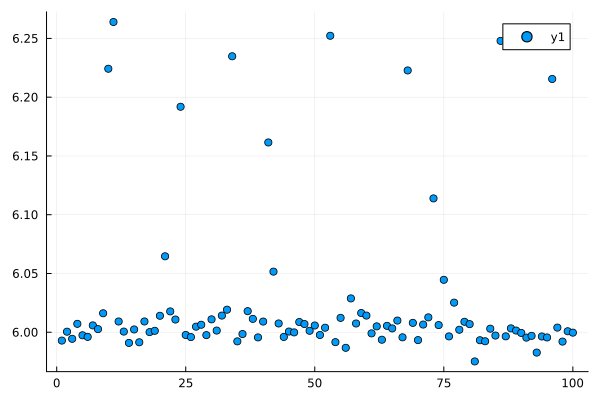

In [63]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

In [64]:
spk_inner = Chain(FlattenLayer(),
                    LayerNorm((28^2,)),
                    x -> tanh.(x), 
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
                    x -> x,
                )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#39),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = WrappedFunction(#40),
)         # Total: 102_176 parameters,
          #        plus 0 states.

In [65]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (128, 128) with 327680 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple())))

In [66]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (128, 128) with 81907 spikes.

In [67]:
st3_b1 = st3[:,1:5]

Spike Train: (128, 5) with 3200 spikes.

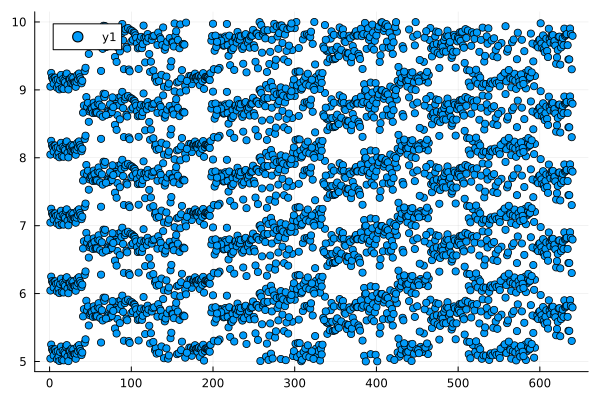

In [68]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [ ]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, :, n_batches), dims=2) ./ num
    return acc
end

fmnist_spiking_accuracy (generic function with 1 method)

In [ ]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

21×1 Matrix{Float64}:
 0.1
 0.1756
 0.7414
 0.8288
 0.8527
 0.8641
 0.8702
 0.8734
 0.8752
 0.8767
 0.8786
 0.8781
 0.8783
 0.8786
 0.8801
 0.8795
 0.8808
 0.8803
 0.8806
 0.0802
 0.079

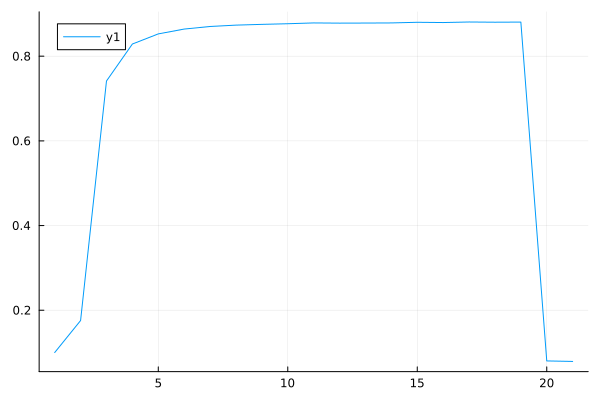

In [ ]:
plot(spk_a)